In [ ]:
# # Need to tap local runtime resources
# !pip install jupyterlab
# !pip install jupyter_http_over_ws
# !jupyter serverextension enable --py jupyter_http_over_ws

In [ ]:
# Setup for Google Colab
#!pip install tensorflow-gpu
!pip install transformers
!git clone https://github.com/CodyBurker/W266_Group_Project
!pip install datasets

fatal: destination path 'W266_Group_Project' already exists and is not an empty directory.


In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Mar 21 23:22:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from transformers import BertTokenizer, TFBertModel, TFBertForSequenceClassification
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
# def read_in_data(path="W266_Group_Project/"):
#     import pandas as pd
#     X_train = pd.read_csv(path + "x_train_sampled_yelp_data.csv")
#     y_train = pd.read_csv(path + "y_train_sampled_yelp_data.csv")
#     X_test = pd.read_csv(path + "x_test_sampled_yelp_data.csv")
#     y_test = pd.read_csv(path + "y_test_sampled_yelp_data.csv")
#     return X_train, X_test, y_train, y_test
# X_train, X_test, y_train, y_test = read_in_data()

In [ ]:
def read_in_data(path="W266_Group_Project/"):
    import pandas as pd
    X_train = pd.read_csv(path + "x_train_balanced.csv")
    y_train = pd.read_csv(path + "y_train_balanced.csv")
    X_test = pd.read_csv(path + "x_test_balanced.csv")
    y_test = pd.read_csv(path + "y_test_balanced.csv")
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = read_in_data()

In [ ]:
X_train['text'][1]

"Will definitely be using Cooper Party Rentals again! Not only do they have more than fair pricing, the owner was super nice and quick to respond to any of my questions or concerns. We rented 4 round tables and 30 white chairs. Everything was dropped off and picked up super conveniently and in a timely manner.  We had initially planned to have our event in May for my sister's grad party and had to reschedule due to COVID. Dane was super understanding and flexible around our new proposed dates."

In [ ]:
y_train['stars'] = y_train['stars'] - 1
y_test['stars'] = y_test['stars'] - 1
# shifting predicted categories down by 1 to work in the sparse_cateforial_entropy loss below 

In [ ]:
y_train['stars']

0        3.0
1        4.0
2        0.0
3        3.0
4        4.0
        ... 
79995    0.0
79996    2.0
79997    0.0
79998    2.0
79999    0.0
Name: stars, Length: 80000, dtype: float64

In [ ]:
# Exploring options from https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-bert-and-hugging-face-294e8a04b671
# from transformers import TFBertForSequenceClassification
# ?TFBertForSequenceClassification

In [ ]:
#from transformers import BertTokenizer, TFBertForSequenceClassification
#import tensorflow as tf

#tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
#model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")

#inputs = tokenizer("Hello, my dog is ugly, mean, and bad", return_tensors="tf")
#inputs["labels"] = tf.reshape(tf.constant(1), (-1, 1))  # Batch size 1

#outputs = model(inputs)
#loss = outputs.loss
#logits = outputs.logits

In [ ]:
# Look at the layers in the BERT base model
#[i.name for i in model.weights]

In [ ]:
# def how_many_tokens(input_examples, tokenizer=tokenizer,
#                     quantiles = [0, .25, .5, .75, 1]):
#   """ 
#   Determine the desired quantiles calculated from the length (in token IDs) of 
#   provided text examples using a desired tokenizer.
  
#   Input: list of examples

#   Output: Number of token IDs at quantiles in any of the given input examples 
#   (excluding special token IDs such as CLS, UNK, SEP) 
#   """ 

#   input_token_id_lengths = []
#   for i in input_examples:
#     tokens = tokenizer.tokenize(i)
#     token_ids = tokenizer.convert_tokens_to_ids(tokens)
#     input_token_id_lengths.append(len(token_ids))

#   return np.quantile(input_token_id_lengths, quantiles), input_token_id_lengths

# # The results of running this function on the training text examples (100K) was
# # 4,406 max token IDs - pretty long - and the below quantiles:
# # array([1.000e+00, 5.600e+01, 1.010e+02, 1.780e+02, 4.406e+03])
# # how_many_tokens(X_train['text'])

# # The results for below, same run on test examples yielded: 
# # array([   2.,   56.,  100.,  178., 1385.])
# # how_many_tokens(X_test['text'])

In [ ]:
# While the max length is 4,406, only 2.2% of examples would be truncated if
# we set the max length at 512 (for padding purposes), as seen below
# quantiles, token_lengths = how_many_tokens(X_train['text'])
# print(quantiles)
# print('Proportion of examples > 512 tokens:', (np.sum(np.array(token_lengths)>512)/(len(token_lengths))))

# Setting max length based on above
# max_length = 512

In [ ]:
# def examples_to_BERT_inputs(input_examples, input_labels, tokenizer=tokenizer, 
#                             max_length=max_length):
#   #c= 0
#   input_ids = []
#   attention_mask = []
#   #labels = []

#   for i in input_examples:
#     encoding = tokenizer.encode_plus(
#         i,
#         truncation = True, 
#         add_special_tokens = True,
#         padding = 'max_length',
#         return_attention_mask = True#,
#         #return_tensors='tf'
#     )

#     input_ids.append(encoding['input_ids'])
#     attention_mask.append(encoding['attention_mask'])
#     #labels.append(input_labels[c])

#     #c+=1

#   return {'input_ids': input_ids, 'attention_mask': attention_mask}

In [ ]:
# Check to see if the base model is performing as expected
# results_base = model(examples_to_BERT_inputs(X_train['text'][:100], y_train['stars'][:100]))

In [ ]:
# results_base

In [ ]:
#Look at the shape of every layer in the pretrained model
#for layer in range(len(bert.layers[0].weights))[:10]:
    #print(layer)
    #print('Layer name: \t', bert.layers[0].weights[layer].name)
    #print('Layer shape: \t', bert.layers[0].weights[layer].shape)

In [ ]:
# tokenizer.tokenize('Testing to see how this BERT tokenizer splits various kinds of words, sometimes unusually')

In [ ]:
# tokenizer.convert_tokens_to_ids([
#                                  '[CLS]', 
#                                  'Testing',
#                                  'to',
#                                  'see',
#                                  'how',
#                                  'this', 
#                                  'works', 
#                                  '[SEP]'])

In [ ]:
# tokenizer.convert_ids_to_tokens([101])

In [ ]:
#Establish bare base pretrained BERT model, and see layers
# bert = TFBertModel.from_pretrained('bert-base-uncased')
# note the model name / path is a string - the *model id* of a pretrained model 
# hosted inside a model repo on huggingface.co

In [ ]:
#curious to see example weights at the first layer
# bert.layers[0].weights[0]

In [ ]:
# Resource used to guide work: 
# https://raviteja-ganta.github.io/sentiment-analysis-using-bert-and-hugging-face

In [ ]:
# outputs[0]

In [ ]:
# train['DATA_COLUMN'] = pd.DataFrame(X_train['text'])
# train['LABEL_COLUMN'] = y_train['stars']
# test['DATA_COLUMN'] = pd.DataFrame(X_test['text'])
# test['LABEL_COLUMN'] = y_test['stars']

# #pd.DataFrame(test[['text', 'stars']])
# test

In [ ]:
# def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
#   train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
#                                                           text_a = x[DATA_COLUMN], 
#                                                           text_b = None,
#                                                           label = x[LABEL_COLUMN]), axis = 1)

#   validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
#                                                           text_a = x[DATA_COLUMN], 
#                                                           text_b = None,
#                                                           label = x[LABEL_COLUMN]), axis = 1)
  
#   return train_InputExamples, validation_InputExamples

#   train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
#                                                                            test, 
#                                                                            'DATA_COLUMN', 
#                                                                            'LABEL_COLUMN')
  
# def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
#     features = [] # -> will hold InputFeatures to be converted later

#     for e in examples:
#         # Documentation is really strong for this method, so please take a look at it
#         input_dict = tokenizer.encode_plus(
#             e.text_a,
#             add_special_tokens=True,
#             max_length=max_length, # truncates if len(s) > max_length
#             return_token_type_ids=True,
#             return_attention_mask=True,
#             pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
#             truncation=True
#         )

#         input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
#             input_dict["token_type_ids"], input_dict['attention_mask'])

#         features.append(
#             InputFeatures(
#                 input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
#             )
#         )

#     def gen():
#         for f in features:
#             yield (
#                 {
#                     "input_ids": f.input_ids,
#                     "attention_mask": f.attention_mask,
#                     "token_type_ids": f.token_type_ids,
#                 },
#                 f.label,
#             )

#     return tf.data.Dataset.from_generator(
#         gen,
#         ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
#         (
#             {
#                 "input_ids": tf.TensorShape([None]),
#                 "attention_mask": tf.TensorShape([None]),
#                 "token_type_ids": tf.TensorShape([None]),
#             },
#             tf.TensorShape([]),
#         ),
#     )


# DATA_COLUMN = 'DATA_COLUMN'
# LABEL_COLUMN = 'LABEL_COLUMN'

In [ ]:
# from transformers import InputExample, InputFeatures
# train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)
# print(train_InputExamples[0])

In [ ]:
# train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
# train_data = train_data.shuffle(100).batch(32).repeat(2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


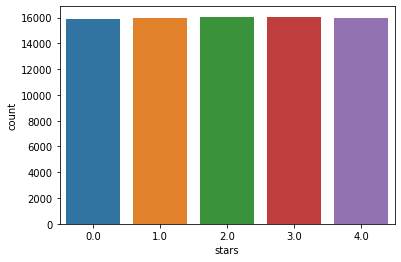

In [ ]:
sns.countplot(y_train['stars'])

In [ ]:
# sns.countplot(y_test['stars'])
# np.unique(y_test, counts=TRUE)

**RESTARTING FROM HERE**

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
[x for x in X_train['text'][:5]]

['This place gives so much food.. I felt like I wasted.. everything was great.. service she was sweet',
 "Will definitely be using Cooper Party Rentals again! Not only do they have more than fair pricing, the owner was super nice and quick to respond to any of my questions or concerns. We rented 4 round tables and 30 white chairs. Everything was dropped off and picked up super conveniently and in a timely manner.  We had initially planned to have our event in May for my sister's grad party and had to reschedule due to COVID. Dane was super understanding and flexible around our new proposed dates.",
 "I watched the woman making my coffee use a dirty rag that she just wiped the counters with on my lid. I asked for a new lid and she gave me an attitude. That's dangerously unsanitary. Train your employees.",
 'Good value, tasty food, quick service. A nice alternative when I get tired of chipotle',
 "I love Yats! I thought I wrote a review for Yats before but maybe I haven't and that's hell

In [ ]:
#import tensorflow_datasets as tfds

# train_data, test_data = tfds.load(
#     name="imdb_reviews", 
#     split=('train[:80%]', 'test[80%:]'),
#     as_supervised=True)

# train_examples_batch, train_labels_batch = next(iter(train_data.batch(20000)))
# test_examples_batch, test_labels_batch = next(iter(test_data.batch(5000)))

In [ ]:
#train_examples_batch[:5]
#train_labels_batch[:5]

In [ ]:
tf.convert_to_tensor(X_train['text'][:5])

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'This place gives so much food.. I felt like I wasted.. everything was great.. service she was sweet',
       b"Will definitely be using Cooper Party Rentals again! Not only do they have more than fair pricing, the owner was super nice and quick to respond to any of my questions or concerns. We rented 4 round tables and 30 white chairs. Everything was dropped off and picked up super conveniently and in a timely manner.  We had initially planned to have our event in May for my sister's grad party and had to reschedule due to COVID. Dane was super understanding and flexible around our new proposed dates.",
       b"I watched the woman making my coffee use a dirty rag that she just wiped the counters with on my lid. I asked for a new lid and she gave me an attitude. That's dangerously unsanitary. Train your employees.",
       b'Good value, tasty food, quick service. A nice alternative when I get tired of chipotle',
       b"I love Yats

In [ ]:
num_train_examples = 80000
num_test_examples = 20000

max_length = 512

X_train_tokenized = tokenizer([str(x.numpy())[2:] for x in tf.convert_to_tensor(X_train['text'][:num_train_examples])], 
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')

y_train_tokenized = tf.convert_to_tensor(y_train['stars'][:num_train_examples])

x_test_tokenized = tokenizer([str(x.numpy())[2:] for x in tf.convert_to_tensor(X_test['text'][:num_test_examples])], 
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')

y_test_tokenized = tf.convert_to_tensor(y_test['stars'][:num_test_examples])

In [ ]:
X_train_tokenized

{'input_ids': <tf.Tensor: shape=(80000, 512), dtype=int32, numpy=
array([[  101,  1188,  1282, ...,     0,     0,     0],
       [  101,  3100,  5397, ...,     0,     0,     0],
       [  101,   146,  2542, ...,     0,     0,     0],
       ...,
       [  101,  5033,  1110, ...,     0,     0,     0],
       [  101, 23158,  1204, ...,     0,     0,     0],
       [  101,  9800, 27788, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(80000, 512), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(80000, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype

In [ ]:
# ?bert_model()

In [ ]:
#bert_out = bert_model(X_train_tokenized)

In [ ]:
#bert_out[0].numpy().shape
# Batch size, max length, encoding

In [ ]:
#bert_out[1].numpy().shape
# this is the classification encoding, which we will feed to the classification layer

In [ ]:
input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids_layer')
token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='token_types_ids_layer')
attention_masks = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_masks_layer')

In [ ]:
bert_inputs = {'input_ids': input_ids,
               'token_type_ids': token_type_ids,
               'attention_masks': attention_masks
               }

In [ ]:
bert_out = bert_model(bert_inputs)[1]

In [ ]:
hidden_out = tf.keras.layers.Dense(200, activation='relu')(bert_out)


In [ ]:
classification_out = tf.keras.layers.Dense(5, activation='sigmoid')(hidden_out)
# Used 6 categories just to see if this would run (knowing there isn't a 6th category)...
# Need to either 1-hot encode the data here (and use categorical cross-entropy) or transform the prediction categories to 0-4 (sparse doesn't like starting at 1 instead of 0)

In [ ]:
classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_masks], outputs=[classification_out])

In [ ]:
# ?tf.keras.losses.SparseCategoricalCrossentropy

In [ ]:
classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.00001), 
                             loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                             metrics='accuracy')

In [ ]:
classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_masks_layer (InputLa  [(None, 512)]       0           []                               
 yer)                                                                                             
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 token_types_ids_layer (InputLa  [(None, 512)]       0           []                               
 yer)                                                                                             
                                                                                              

In [ ]:
classification_model.fit([X_train_tokenized.input_ids, X_train_tokenized.token_type_ids, X_train_tokenized.attention_mask],
                         y_train_tokenized,
                         validation_data=([x_test_tokenized.input_ids, x_test_tokenized.token_type_ids, x_test_tokenized.attention_mask],
                                          y_test_tokenized),
                         epochs=3,
                         batch_size=10)

Epoch 1/3
8000/8000 [==============================] - 6012s 751ms/step - loss: 0.8818 - accuracy: 0.6093 - val_loss: 0.7539 - val_accuracy: 0.6694
Epoch 2/3
8000/8000 [==============================] - 6004s 751ms/step - loss: 0.7006 - accuracy: 0.6956 - val_loss: 0.7452 - val_accuracy: 0.6712
Epoch 3/3
8000/8000 [==============================] - 6005s 751ms/step - loss: 0.5896 - accuracy: 0.7472 - val_loss: 0.7750 - val_accuracy: 0.6747


In [ ]:
predictions = classification_model.predict([X_train_tokenized.input_ids, X_train_tokenized.token_type_ids, X_train_tokenized.attention_mask]#,
                             #batch_size=1,
                             #steps=80000)
)

In [ ]:
preds = []
for pred in predictions:
  preds.append(np.argmax(pred))

np.unique(preds)

array([0, 1, 2, 3, 4])

In [ ]:
predictions.shape

(80000, 5)

In [ ]:
predictions

array([[0.03626691, 0.05791741, 0.21747778, 0.62491596, 0.83137155],
       [0.00969902, 0.01243679, 0.07472925, 0.89667344, 0.9892826 ],
       [0.9854854 , 0.7612911 , 0.2053543 , 0.02133091, 0.02478397],
       ...,
       [0.97351855, 0.8721985 , 0.31855977, 0.01945437, 0.01431295],
       [0.01162514, 0.36174682, 0.97523266, 0.78721195, 0.05085443],
       [0.99668056, 0.58956647, 0.12467027, 0.01727189, 0.02502814]],
      dtype=float32)

In [ ]:
predictions.to_csv('BERT_Predictions_80k.csv', index=False)

In [ ]:
(np.sum(y_train['stars'][:num_train_examples] == 4)) / (len(y_train['stars'][:num_train_examples]))
# Train 5s

0.199775

In [ ]:
(np.sum(y_test['stars'][:num_test_examples] == 4)) / (len(y_test['stars'][:num_test_examples]))
# Test 5s (baseline)

0.2009

In [ ]:
np.sum(y_test['stars'][:num_test_examples] == 0)

4089

In [ ]:
np.unique(y_test['stars'][:num_test_examples])

array([0., 1., 2., 3., 4.])

**Problems to Address**
* Need to tap into local resources (GPU) to speed processing - may need to specify in the model to utilize the GPU (and change runtime settings)
* ***RESOLVED*** Accuracy could be quite low because of such a small data set
* ***INCORPORATED*** We should get another dataset that is class-balanced
* ***FIXED:*** Loss is way too low... need to investigate this, because it should start higher... first thought was learning rate was too high, but stayed the same at .01 Adam. Maybe this has more to do with the # of categories, which would exmplain the low accuracy and the low loss
* ***DONE:*** Need to resolve the wrong number of categories predicted (should be 5, only returning 1)... I think I have the wrong number of neurons in the final prediction layers